<a href="https://colab.research.google.com/github/beluash/skudina_clip1/blob/main/SkidinaVictoria_TestClip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install ftfy tqdm regex
!pip install ipyplot

In [ ]:
!pip install flask==0.12.2
!pip install flask-ngrok

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#!git config --global user.email "v.skudina@g.nsu.ru"
#!git config --global user.name "Victoria Skudina"
#!git init Skudina_TestClip
#%cd Skudina_TestClip
#!ls -a
!git add .
#!git branch -M main
#!git commit -m "First commit"
#!git branch -M main
#!git remote add origin https://{f1cc5ec15edbb97943387b5ced95672d8a3f2396}@github.com/{beluash}/{Skudina_TestClip}.git
#!git push -u origin main
#!git push -u origin master
#!git status

In [40]:
#!git remote add origin https://github.com/beluash/Skudina_TestClip.git
!git push -u origin main

fatal: unable to access 'https://{f1cc5ec15edbb97943387b5ced95672d8a3f2396}@github.com/{beluash}/{Skudina_TestClip}.git/': The requested URL returned error: 400


In [31]:
!git remote add origin https://f1cc5ec15edbb97943387b5ced95672d8a3f2396@github.com/beluash/Skudina_TestClip.git

fatal: remote origin already exists.


 # Imports

# Новый раздел

In [ ]:
import torch
from torchvision import transforms
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
import math
import numpy as np
import pandas as pd
import os
import sys
from random import randint
from IPython.display import display, Image as Img
import ipyplot

from flask_ngrok import run_with_ngrok
from flask import Flask


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


# Clean dataset

In [ ]:
data_cleaned = False

os.makedirs("features", exist_ok=True) 
cur_path = os.getcwd()

# Set the path to the photos
photos_path = Path("/content/drive/MyDrive/Downloads") #/ "photos"

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))

features_path = Path(os.path.join(os. getcwd(),"features"))
# Print some statistics
print(f"Photos found: {len(photos_files)}")

Photos found: 86


In [ ]:
# # clean
# check exif corrupt of not rgb

if not data_cleaned:
  for img in tqdm(photos_files):           
      try:
          image = Image.open(img)
          exif_data = image._getexif()     
          if image.mode != 'RGB':
              try:
                  os.remove(img) 
                  print(f"corrupted image {img} deleted")
              except FileNotFoundError as e:
                  print(sys.exc_info()[0])  
                  
      except:
          print(sys.exc_info()[0])
          try:
              os.remove(img) 
              print(f"corrupted image {img} deleted")
          except: 
            print(img,"no image")
           
  data_cleaned = True
  print("dataset is cleaned")


dataset is cleaned


# CLIP


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
#check drivers
print("Is cuda available: " ,torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Is cuda available:  True


In [ ]:
if not os.path.isfile(os.path.join(os. getcwd(),"CLIP")):
  !git clone https://github.com/openai/CLIP.git
%cd CLIP
from clip import clip
model, preprocess = clip.load("ViT-B/32", device=device)
os.chdir("/content")

Cloning into 'CLIP'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.
/content/CLIP


100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 131MiB/s]


In [ ]:
is_fp16 = False
if is_fp16:
    model.to(device=device).eval().half()
    print("fp16: Enabled")
else:
    model.to(device=device).eval()#.float()


input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Preprocess 

In [ ]:
# Function that computes the feature vectors for a batch of images

def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
     
        photos_features /= photos_features.norm(dim=-1, keepdim=True)
        

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [ ]:
# Make embeddings

batch_size = 16
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in tqdm(range(batches)):
    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    batch_files = photos_files[i*batch_size : (i+1)*batch_size]
    batch_features = compute_clip_features(batch_files)
    np.save(batch_features_path, batch_features)
    photo_ids = [photo_file for photo_file in batch_files]
    photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
    photo_ids_data.to_csv(batch_ids_path, index=False)

In [ ]:
# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector from the GPU and convert it to a numpy array
  return text_encoded.cpu().numpy()

def display_photo(photo_id):
  display(Img(photo_id))
  

Photos loaded: 86


In [ ]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)
  scores = sorted(similarities,reverse=True)[:results_count]
  best_photo_idx = np.argsort(similarities)[::-1]
  # Return the photo IDs of the best matches
  return [photo_ids['photo_id'].iloc[i] for i in best_photo_idx[:results_count]],scores

In [ ]:
def search_with_model(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids, scores = find_best_matches(text_features, photo_features, photo_ids, results_count)
  all_images = []
  # Display the best photos
  for photo_id in best_photo_ids:
    # display_photo(photo_id)
    image = Image.open(photo_id)
    all_images.append(image)

  ipyplot.plot_images(all_images,scores,max_images=results_count,img_width=150)

In [ ]:
photo_features = np.load(os.path.join(features_path,"features.npy"))

In [ ]:
#окно браузера
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run


@app.route("/")
def home():
    return "<h1>Hello! Please enter a word to search: </h1>"
  
app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7f99d07c24f3.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Mar/2021 12:37:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2021 12:37:59] "GET /favicon.ico HTTP/1.1" 404 -


search: sad
sad



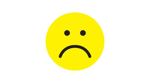
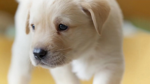
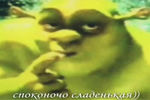
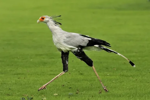
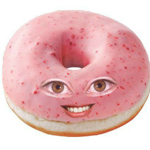


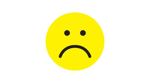
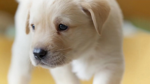
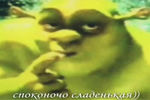
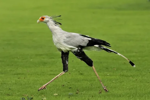
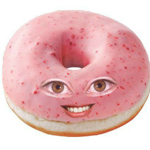

In [ ]:
promt = input("search: ")
print(promt)
search_with_model(promt, photo_features, photo_ids, 5)